In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
transforms = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])
])
train_set = datasets.ImageFolder("/content/drive/My Drive/data/train",transforms)
val_set = datasets.ImageFolder("/content/drive/My Drive/data/val",transforms)
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(512, 2)     # modify the number of output features to 2

In [10]:
print(train_set.class_to_idx)
print(train_set.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


In [11]:
import numpy as np

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)                                        
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, label="Training loss", linewidth=2)
    plt.plot(x, val_history, label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

print(model.cuda())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


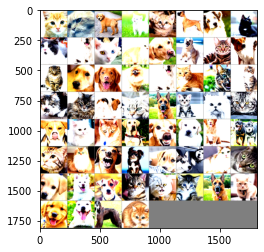

In [12]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
import matplotlib.pyplot as plt
imshow(torchvision.utils.make_grid(images))

In [13]:
net = model.cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_history = []
test_loss_history = []
num_epochs = 20

for epoch in range(num_epochs):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(train_loader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(val_loader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(train_loader)
  test_loss = test_loss/len(val_loader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.9256500005722046, Test loss 0.5626359581947327
Epoch 1, Train loss 0.551868736743927, Test loss 0.38394680619239807
Epoch 2, Train loss 0.3335025906562805, Test loss 0.2526123821735382
Epoch 3, Train loss 0.21180881559848785, Test loss 0.20534275472164154
Epoch 4, Train loss 0.15778779983520508, Test loss 0.17697924375534058
Epoch 5, Train loss 0.12992914021015167, Test loss 0.15710902214050293
Epoch 6, Train loss 0.11017726361751556, Test loss 0.14161454141139984
Epoch 7, Train loss 0.09528534859418869, Test loss 0.12915372848510742
Epoch 8, Train loss 0.08368397504091263, Test loss 0.11893186718225479
Epoch 9, Train loss 0.07441035658121109, Test loss 0.11037051677703857
Epoch 10, Train loss 0.06683533638715744, Test loss 0.10307242721319199
Epoch 11, Train loss 0.06053643673658371, Test loss 0.09678897261619568
Epoch 12, Train loss 0.055232200771570206, Test loss 0.09131091088056564
Epoch 13, Train loss 0.05071592330932617, Test loss 0.08649060875177383
Epoch 1

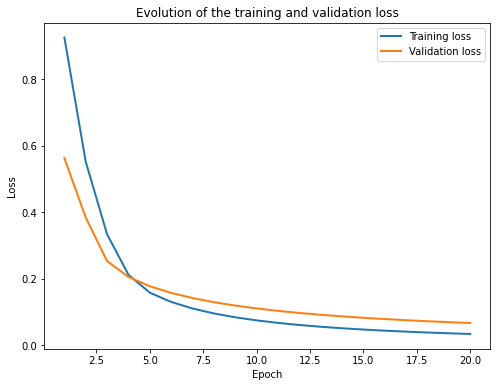

In [14]:
plot_losses(train_loss_history, test_loss_history)

In [15]:
def evaluate(dataloader):
  total, correct = 0, 0
  net.eval() # don't update weights
  for data in dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    predicted_output = net(images)
    _, predicted_labels = torch.max(predicted_output,1)
    total += labels.size(0)
    correct += (predicted_labels == labels).sum().item()
  return 100 * correct/total

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(train_loader), evaluate(val_loader)))

Train acc = 100.00, test acc = 100.00
